   TRANSACTION_ID  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  \
0               0          596         3156      57.16               31   
1               1         4961         3412      81.51              130   
2               2            2         1365     146.00              476   
3               3         4128         8737      64.49              569   
4               4          927         9906      50.99              634   

   TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0             0         0                  0  
1             0         0                  0  
2             0         0                  0  
3             0         0                  0  
4             0         0                  0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TRANSACTION_ID     int64  
 1   CUSTOMER_ID        int64  
 2   TERMINAL_ID        int

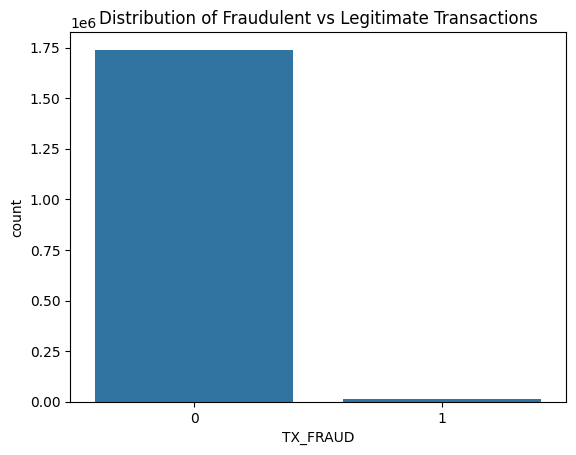

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


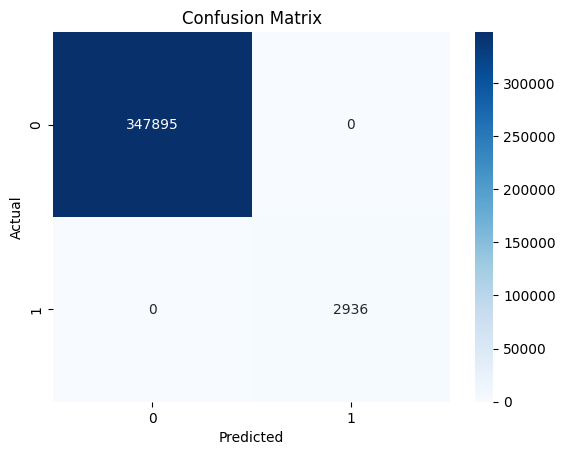

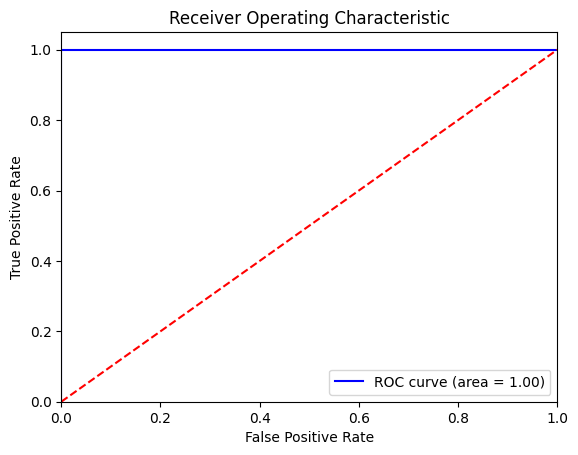

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv(r"C:\Users\taniy\Downloads\combined_fraud_data.csv")

# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())

# Handle missing values (if any)
df.dropna(inplace=True)

# Check the column names
print(df.columns)

# Convert the date-time column to the appropriate data type
date_time_columns = [col for col in df.columns if 'DATE' in col or 'TIME' in col]
if date_time_columns:
    for col in date_time_columns:
        df[col] = pd.to_datetime(df[col])
    df['TX_DATETIME'] = pd.to_datetime(df[date_time_columns[0]])
    df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
    df['TX_WEEKDAY'] = df['TX_DATETIME'].dt.day_name()
else:
    raise ValueError("No date-time column found in the dataset.")

# Extract additional features from the date-time column
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_WEEKDAY'] = df['TX_DATETIME'].dt.day_name()

# Visualize class distribution
sns.countplot(x='TX_FRAUD', data=df)
plt.title('Distribution of Fraudulent vs Legitimate Transactions')
plt.show()

# Feature encoding
df = pd.get_dummies(df, columns=['TX_WEEKDAY'], drop_first=True)

# Feature scaling
scaler = StandardScaler()
df[['TX_AMOUNT']] = scaler.fit_transform(df[['TX_AMOUNT']])

# Split the data into training and testing sets
X = df.select_dtypes(exclude=['datetime64[ns]'])
y = df['TX_FRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a machine learning model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize the ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Optimize the model (Grid Search)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Deploy the model and use it for fraud detection
new_transaction = {
    'TRANSACTION_ID': 123456,
    'TRANSACTION_DATE': '2023-05-01',
    'TRANSACTION_TIME': '12:34:56',
    'CUSTOMER_ID': 10001,
    'TERMINAL_ID': 20001,
    'TX_AMOUNT': 250.0
}

new_transaction_df = pd.DataFrame([new_transaction])
new_transaction_df['TX_DATETIME'] = pd.to_datetime(new_transaction_df['TRANSACTION_DATE'] + ' ' + new_transaction_df['TRANSACTION_TIME'])
new_transaction_df['TX_HOUR'] = new_transaction_df['TX_DATETIME'].dt.hour
new_transaction_df['TX_WEEKDAY'] = new_transaction_df['TX_DATETIME'].dt.day_name()
new_transaction_df = pd.get_dummies(new_transaction_df, columns=['TX_WEEKDAY'], drop_first=True)
new_transaction_df[['TX_AMOUNT']] = scaler.transform(new_transaction_df[['TX_AMOUNT']])

# Ensure the new transaction DataFrame has the same structure as the training data
new_transaction_df = new_transaction_df.reindex(columns=X.columns, fill_value=0)

prediction = best_model.predict(new_transaction_df)
if prediction[0] == 1:
    print("The transaction is fraudulent.")
else:
    print("The transaction is legitimate.")
